In [2]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

matplotlib.rcParams["animation.embed_limit"] = 5 * 1024 * 1024 # 5MB
matplotlib.rcParams["animation.ffmpeg_path"] = "ffmpeg"

In [3]:
## TO remove warnings about runtime warnings in the gradient descent
import warnings
warnings.simplefilter("ignore")

In [4]:
from functions import Beale, Booth, Rosenbrock
from optimizers import SGD, SGD_Momentum, AdaGrad, RMSProp, Adam
from functions_config import BEALE_CONFIG, BOOTH_CONFIG, ROSENBROCK_CONFIG
from animations import  TrajectoryAnimation3D

**Function for the gradient descent**

In [5]:
def optimize(func, grad_func, optimizer, initial_point, n_iter=100000, epsilon=1e-4):

    params = initial_point
    opt_path = []
    old_loss = 0.0
    convergence = False

    for it in range(n_iter):

        loss = func(*params)

        if np.abs(loss - old_loss) <= epsilon:
            print(
                f"Optimizer {optimizer.__class__.__name__} converged in {it} iterations"
            )
            convergence = True
            break

        opt_path.append(params)
        grad_params = grad_func(*params)
        params = optimizer.step(params, grad_params)
        old_loss = loss
        
    if not convergence:
        print(
            f"Optimizer {optimizer.__class__.__name__} did not converge in {n_iter} iterations"
        )

    return params, np.array(opt_path)

First, we wil do an example with the Beale function.

In [ ]:
function = Beale(**BEALE_CONFIG)

x_min, x_max, x_step = BEALE_CONFIG["x_min"], BEALE_CONFIG["x_max"], BEALE_CONFIG["step_size"]
y_min, y_max, y_step = BEALE_CONFIG["x_min"], BEALE_CONFIG["y_max"], BEALE_CONFIG["step_size"]

x, y = np.meshgrid(np.arange(x_min, x_max + x_step, x_step), np.arange(y_min, y_max + y_step, y_step))
z = function(x, y)

In [ ]:
all_optimizers = [
    SGD(),
    SGD_Momentum(),
    AdaGrad(),
    RMSProp(),
    Adam(),
]

all_end_values = []
optimization_paths = []

for optimizer in all_optimizers:
    initial_point = np.array(BEALE_CONFIG["initial_point"])
    end_values, opt_path = optimize(function, function.grad, optimizer, initial_point)
    all_end_values.append(end_values)
    optimization_paths.append(opt_path)

In [ ]:
methods = [optimizer.__class__.__name__ for optimizer in all_optimizers]

In [6]:
def sample_path(path, total_sample):
    path_len = len(path)
    if path_len < total_sample:
        return path
    else:
        indices = np.linspace(0, path_len - 1, total_sample, dtype=int)
        return path[indices]

In [ ]:
total_sample = 100
sampled_paths = [sample_path(path, total_sample) for path in optimization_paths]
sampled_paths = [path.T for path in sampled_paths]
zpaths = [function(*path) for path in sampled_paths]

In [ ]:
fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(x,y,z,rstride=1,cstride=1,edgecolor="none",norm=LogNorm(),alpha=0.7,cmap=plt.cm.jet,zorder=0)

minima_x, minima_y = function.minima[:, 0], function.minima[:, 1]
minima_z = function(minima_x, minima_y)

initial_x, initial_y = BEALE_CONFIG["initial_point"]
initial_z = function(initial_x, initial_y)

combined_x = np.append(minima_x, initial_x)
combined_y = np.append(minima_y, initial_y)
combined_z = np.append(minima_z, initial_z)

ax.scatter3D(combined_x,combined_y,combined_z.reshape(-1, 1),marker="*",s=100,zorder=7)

ax.set_title(f"{function} function optimization")
ax.view_init(elev=45, azim=45)

anim = TrajectoryAnimation3D(*sampled_paths, zpaths=zpaths, labels=methods, fig=fig, ax=ax)

ax.legend(loc="upper right")

In [ ]:
HTML(anim.to_html5_video())

you may have to change the file art3d in the python library \Lib\site-packages\mpl_toolkits\mplot3d\art3d.py  
In the lines 173,174 you must change xs, ys  
xs = np.asarray(self.get_xdata())  
ys = np.asarray(self.get_ydata())  

In [ ]:
# anim.save("beale_3d_animation.mp4", fps=60)

In [7]:
def animate_function(function_instance, config, total_sample=100):
    function = function_instance(**config)

    x_min, x_max, x_step = config["x_min"], config["x_max"], config["step_size"]
    y_min, y_max, y_step = config["x_min"], config["y_max"], config["step_size"]

    x, y = np.meshgrid(np.arange(x_min, x_max + x_step, x_step), np.arange(y_min, y_max + y_step, y_step))
    z = function(x, y)
    all_optimizers = [
        SGD(),
        SGD_Momentum(),
        AdaGrad(),
        RMSProp(),
        Adam(),
    ]

    all_end_values = []
    optimization_paths = []

    for optimizer in all_optimizers:
        initial_point = np.array(config["initial_point"])
        end_values, opt_path = optimize(function, function.grad, optimizer, initial_point)
        all_end_values.append(end_values)
        optimization_paths.append(opt_path)

    methods = [optimizer.__class__.__name__ for optimizer in all_optimizers]

    sampled_paths = [sample_path(path, total_sample) for path in optimization_paths]
    sampled_paths = [path.T for path in sampled_paths]
    zpaths = [function(*path) for path in sampled_paths]

    fig = plt.figure(figsize=(12, 8))

    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(x,y,z,rstride=1,cstride=1,edgecolor="none",norm=LogNorm(),alpha=0.7,cmap=plt.cm.jet,zorder=0)

    minima_x, minima_y = function.minima[:, 0], function.minima[:, 1]
    minima_z = function(minima_x, minima_y)

    initial_x, initial_y = config["initial_point"]
    initial_z = function(initial_x, initial_y)

    ax.scatter3D(minima_x,minima_y,minima_z.reshape(-1, 1),marker="*",s=60,zorder=5)
    ax.scatter3D(initial_x,initial_y,initial_z,marker="o",color= "blue", s=60,zorder=5)

    ax.set_title(f"{function_instance.__name__} Function", fontdict={"fontsize": 20})
    ax.view_init(elev=45, azim=45)

    anim = TrajectoryAnimation3D(*sampled_paths, zpaths=zpaths, labels=methods, fig=fig, ax=ax)

    ax.legend(loc="upper right")
    
    HTML(anim.to_html5_video())
    anim.save(f"{function_instance.__name__}_visualization.mp4", fps=30)

Optimizer SGD converged in 227 iterations
Optimizer SGD_Momentum converged in 112 iterations
Optimizer AdaGrad did not converge in 100000 iterations
Optimizer RMSProp converged in 1105 iterations
Optimizer Adam converged in 15628 iterations


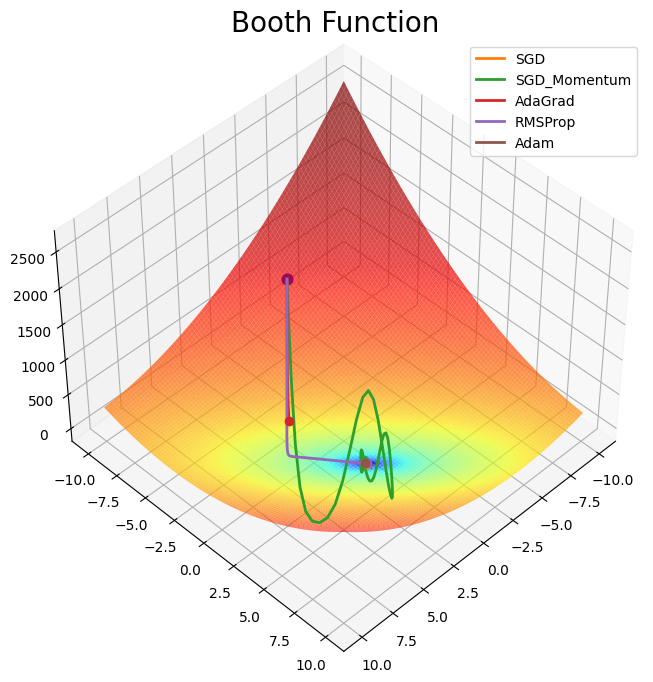

In [8]:
func = Booth
config = BOOTH_CONFIG
animate_function(func, config, total_sample=200)